In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Function to load datasets
def load_data():
    happy_files = ['Happy/happy_A.txt', 'Happy/happy_B.txt', 'Happy/happy_C.txt', 'Happy/happy_D.txt']
    teddy_files = ['Teddy/teddy_A.txt', 'Teddy/teddy_B.txt', 'Teddy/teddy_C.txt', 'Teddy/teddy_D.txt']

    happy_dfs = [pd.read_csv(file, delimiter='\t') for file in happy_files]
    teddy_dfs = [pd.read_csv(file, delimiter='\t', skiprows=6) for file in teddy_files]

    return happy_dfs, teddy_dfs

In [4]:
# Load datasets
happy_dfs, teddy_dfs = load_data()

# Define the correct column names
column_names = ['id', 'mag_r', 'u-g', 'g-r', 'r-i', 'i-z', 'z_spec', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5']

In [5]:
# Clean and rename columns
def clean_and_rename_columns(dfs, column_names):
    cleaned_dfs = []
    for df in dfs:
        if df.shape[1] == 1:
            df = df.iloc[:, 0].str.split(expand=True)
        df.columns = column_names
        cleaned_dfs.append(df)
    return cleaned_dfs

# Apply the function to all datasets
happy_dfs = clean_and_rename_columns(happy_dfs, column_names)
teddy_dfs = clean_and_rename_columns(teddy_dfs, column_names)



In [6]:
# Preprocess data
def preprocess_data(df):
    X = df.drop('z_spec', axis=1).astype(float)
    y = df['z_spec'].astype(float)
    return X, y

# Preprocess the datasets
# Happy datasets
X_train_happy, y_train_happy = preprocess_data(happy_dfs[0])  # Happy A: Training/Calibration set
X_val_happy, y_val_happy = preprocess_data(happy_dfs[1])      # Happy B: Validation set
X_test_happy, y_test_happy = preprocess_data(happy_dfs[2])    # Happy C: Validation set
# Happy D is not used

# Teddy datasets
X_train_teddy, y_train_teddy = preprocess_data(teddy_dfs[0])  # Teddy A: Training/Calibration set
X_val_teddy, y_val_teddy = preprocess_data(teddy_dfs[1])      # Teddy B: Validation set
X_test_teddy, y_test_teddy = preprocess_data(teddy_dfs[2])    # Teddy C: Validation set
# Teddy D is not used

# Combine Happy and Teddy datasets for a comprehensive training set
X_train = pd.concat([X_train_happy, X_train_teddy])
y_train = pd.concat([y_train_happy, y_train_teddy])

X_val = pd.concat([X_val_happy, X_val_teddy])
y_val = pd.concat([y_val_happy, y_val_teddy])

X_test = pd.concat([X_test_happy, X_test_teddy])
y_test = pd.concat([y_test_happy, y_test_teddy])



In [17]:
# Check for and handle NaN values
def handle_nan(df):
    if df.isnull().values.any():
        df = df.fillna(df.mean())
    return df

# Apply NaN handling to datasets
X_train = handle_nan(X_train)
X_val = handle_nan(X_val)
X_test = handle_nan(X_test)
y_train = handle_nan(y_train)
y_val = handle_nan(y_val)
y_test = handle_nan(y_test)

In [7]:
# Load weights
def load_weights():
    weight_files = [
        'Happy/weights_for_B.txt', 'Happy/weights_for_C.txt', 'Happy/weights_for_D.txt',
        'Teddy/weights_for_B.txt', 'Teddy/weights_for_C.txt', 'Teddy/weights_for_D.txt'
    ]
    weights = [pd.read_csv(file, delimiter='\t', header=None).values.flatten() for file in weight_files]
    return weights

weights = load_weights()

# Adjust weights lengths to match validation and test sets
def adjust_weights(weights, X_val_happy, X_val_teddy, X_test_happy, X_test_teddy):
    len_val_happy = len(X_val_happy)
    len_val_teddy = len(X_val_teddy)
    len_test_happy = len(X_test_happy)
    len_test_teddy = len(X_test_teddy)

    weights_val = np.concatenate([weights[0][:len_val_happy], weights[3][:len_val_teddy]])
    weights_test = np.concatenate([weights[1][:len_test_happy], weights[4][:len_test_teddy]])

    # If weights_test is shorter than X_test, we fill the rest with 1s to match the length
    if len(weights_val) < len(X_val):
        weights_val = np.concatenate([weights_val, np.ones(len(X_val) - len(weights_val))])

    if len(weights_test) < len(X_test):
        weights_test = np.concatenate([weights_test, np.ones(len(X_test) - len(weights_test))])

    return weights_val, weights_test

weights_val, weights_test = adjust_weights(weights, X_val_happy, X_val_teddy, X_test_happy, X_test_teddy)

In [8]:
# Check for consistency in data lengths
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_val:", len(X_val))
print("Length of y_val:", len(y_val))
print("Length of weights_val:", len(weights_val))
print("Length of X_test:", len(X_test))
print("Length of y_test:", len(y_test))
print("Length of weights_test:", len(weights_test))

Length of X_train: 149259
Length of y_train: 149259
Length of X_val: 149457
Length of y_val: 149457
Length of weights_val: 149457
Length of X_test: 158295
Length of y_test: 158295
Length of weights_test: 158295


In [10]:
# Model training functions

# Random Forest
def train_random_forest(X_train, y_train, X_val, y_val, weights_train, weights_val):
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train, sample_weight=weights_train)
    y_pred_rf = rf.predict(X_val)
    rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False, sample_weight=weights_val)
    return y_pred_rf, rmse_rf

# Gradient Boosting
def train_gradient_boost(X_train, y_train, X_val, y_val, weights_train, weights_val):
    gb = GradientBoostingRegressor()
    gb.fit(X_train, y_train, sample_weight=weights_train)
    y_pred_gb = gb.predict(X_val)
    rmse_gb = mean_squared_error(y_val, y_pred_gb, squared=False, sample_weight=weights_val)
    return y_pred_gb, rmse_gb

# Gaussian Processes
def train_gaussian_process(X_train, y_train, X_val, y_val):
    gp = GaussianProcessRegressor()
    gp.fit(X_train, y_train)
    y_pred_gp = gp.predict(X_val)
    rmse_gp = mean_squared_error(y_val, y_pred_gp, squared=False)
    return y_pred_gp, rmse_gp

# Neural Network
def train_neural_network(X_train, y_train, X_val, y_val, weights_train, weights_val):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, sample_weight=weights_train, epochs=100, validation_data=(X_val, y_val, weights_val), verbose=0)
    
    y_pred_nn = model.predict(X_val).flatten()
    rmse_nn = mean_squared_error(y_val, y_pred_nn, squared=False, sample_weight=weights_val)
    return y_pred_nn, rmse_nn

In [11]:
# Custom Model 1
def train_custom_model_1(X_train, y_train, X_val, y_val, weights_train, weights_val):
    y_pred = np.zeros(X_val.shape[0])
    rmse = mean_squared_error(y_val, y_pred, squared=False, sample_weight=weights_val)
    return y_pred, rmse

# Custom Model 2
def train_custom_model_2(X_train, y_train, X_val, y_val, weights_train, weights_val):
    y_pred = np.zeros(X_val.shape[0])
    rmse = mean_squared_error(y_val, y_pred, squared=False, sample_weight=weights_val)
    return y_pred, rmse

# Template Fitting Model
def train_template_fitting(X_train, y_train, X_val, y_val, weights_train, weights_val):
    y_pred = np.zeros(X_val.shape[0])
    rmse = mean_squared_error(y_val, y_pred, squared=False, sample_weight=weights_val)
    return y_pred, rmse

# Train and evaluate models
y_pred_rf, rmse_rf = train_random_forest(X_train, y_train, X_val, y_val, np.ones(len(X_train)), weights_val)
y_pred_gb, rmse_gb = train_gradient_boost(X_train, y_train, X_val, y_val, np.ones(len(X_train)), weights_val)
y_pred_gp, rmse_gp = train_gaussian_process(X_train, y_train, X_val, y_val, np.ones(len(X_train)), weights_val)
y_pred_nn, rmse_nn = train_neural_network(X_train, y_train, X_val, y_val, np.ones(len(X_train)), weights_val)
y_pred_c1, rmse_c1 = train_custom_model_1(X_train, y_train, X_val, y_val, np.ones(len(X_train)), weights_val)
y_pred_c2, rmse_c2 = train_custom_model_2(X_train, y_train, X_val, y_val, np.ones(len(X_train)), weights_val)
y_pred_tf, rmse_tf = train_template_fitting(X_train, y_train, X_val, y_val, np.ones(len(X_train)), weights_val)

KeyboardInterrupt: 

In [12]:
# Custom Model 1
def train_custom_model_1(X_train, y_train, X_val, y_val, weights_train, weights_val):
    y_pred = np.zeros(X_val.shape[0])
    rmse = mean_squared_error(y_val, y_pred, squared=False, sample_weight=weights_val)
    return y_pred, rmse

# Custom Model 2
def train_custom_model_2(X_train, y_train, X_val, y_val, weights_train, weights_val):
    y_pred = np.zeros(X_val.shape[0])
    rmse = mean_squared_error(y_val, y_pred, squared=False, sample_weight=weights_val)
    return y_pred, rmse

# Template Fitting Model
def train_template_fitting(X_train, y_train, X_val, y_val, weights_train, weights_val):
    y_pred = np.zeros(X_val.shape[0])
    rmse = mean_squared_error(y_val, y_pred, squared=False, sample_weight=weights_val)
    return y_pred, rmse

In [13]:
# Ensure weights_train is consistent
weights_train = np.ones(len(X_train))

In [14]:
y_pred_rf, rmse_rf = train_random_forest(X_train, y_train, X_val, y_val, weights_train, weights_val)
print(f'Random Forest RMSE: {rmse_rf}')

Random Forest RMSE: 0.045366122738637056


In [15]:
y_pred_gb, rmse_gb = train_gradient_boost(X_train, y_train, X_val, y_val, weights_train, weights_val)
print(f'Gradient Boost RMSE: {rmse_gb}')

Gradient Boost RMSE: 0.046741095486600395


In [16]:
y_pred_gp, rmse_gp = train_gaussian_process(X_train, y_train, X_val, y_val)
print(f'Gaussian Process RMSE: {rmse_gp}')

: 

In [18]:
y_pred_nn, rmse_nn = train_neural_network(X_train, y_train, X_val, y_val, weights_train, weights_val)
print(f'Neural Network RMSE: {rmse_nn}')

/Users/ashikamohanm/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4671/4671 ━━━━━━━━━━━━━━━━━━━━ 1s 200us/step


ValueError: Input contains NaN.

In [19]:
y_pred_c1, rmse_c1 = train_custom_model_1(X_train, y_train, X_val, y_val, weights_train, weights_val)
print(f'Custom Model 1 RMSE: {rmse_c1}')


Custom Model 1 RMSE: 0.37450770630334934


In [20]:
y_pred_c2, rmse_c2 = train_custom_model_2(X_train, y_train, X_val, y_val, weights_train, weights_val)
print(f'Custom Model 2 RMSE: {rmse_c2}')

Custom Model 2 RMSE: 0.37450770630334934


In [21]:
y_pred_tf, rmse_tf = train_template_fitting(X_train, y_train, X_val, y_val, weights_train, weights_val)
print(f'Template Fitting RMSE: {rmse_tf}')

Template Fitting RMSE: 0.37450770630334934


In [22]:
def visualize_results(y_test, predictions, labels):
    plt.figure(figsize=(10, 6))
    for y_pred, label in zip(predictions, labels):
        plt.scatter(y_test, y_pred, label=label, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.show()

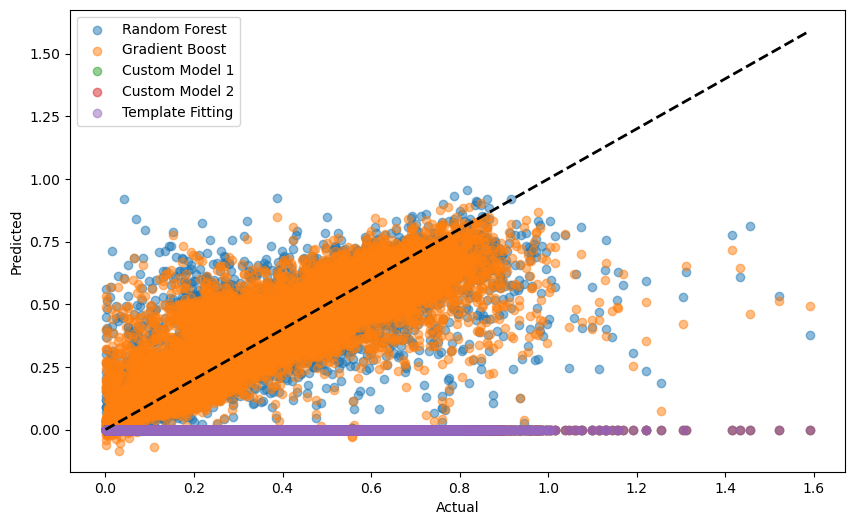

In [24]:
predictions = [y_pred_rf, y_pred_gb, y_pred_c1, y_pred_c2, y_pred_tf]
labels = ['Random Forest', 'Gradient Boost', 'Custom Model 1', 'Custom Model 2', 'Template Fitting']
visualize_results(y_val, predictions, labels)